<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Tf-idf-и-логистическая-регрессия" data-toc-modified-id="Tf-idf-и-логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tf-idf и логистическая регрессия</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [27]:
#pip install eli5

     |████████████████████████████████| 216 kB 1.4 MB/s eta 0:00:01
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=c749ad946514c0494dc1b29de30eabc13612857c9331df3fb9560483c717ccc1
  Stored in directory: /home/jovyan/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.sparse import hstack

#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords

import string

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

import catboost
from catboost import Pool, CatBoostClassifier

from tqdm import tqdm, tqdm_notebook, notebook

from joblib import dump, load

import eli5

import matplotlib.pyplot as plt
import seaborn as sns

#import torch
#from transformers import BertTokenizer, BertModel, BertForMaskedLM

import gc

DATA_PREPARED_FILE = "toxic_comments_ready"
GRID_FILE = "grid_nlp"
MODEL_FILE = "toxic_comments_model"


PATH = '/datasets/'
SEED = 21

## Подготовка

In [2]:
# Загружаем данные 
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.sample(5)

,text,toxic
61882,"""\n\n Hello Alun, thank you for your contribut...",0
156949,Glad you had a good time. I chickened out I'm ...,0
151761,"""\nKingpin, thank you, I think that would be a...",0
123575,So WP:NPA and WP:CIV apply with considerably a...,0
95342,You would think with all that cash he could af...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
#Проверим наличе дубликатов.
df.duplicated().sum()

0

<AxesSubplot:>

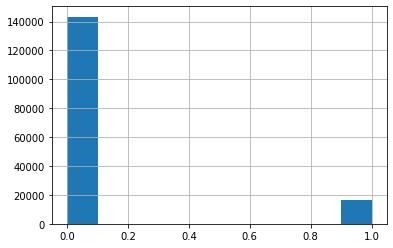

In [6]:
# Взгляним на ,баланс целевого признака.
df['toxic'].hist()

Присутсвует сильный дизбаланс классов.

### Предобработка 

**Очистка**

Очистим тексты с помощию регулярных выражений:

 - Приведем все к нижнему регистру
 - Удалим спец символы \n \r
 - Выберем только слова

In [15]:
def clean(text):
    text = text.lower()
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    
    return text 

In [22]:
df['clean_text'] = df['text'].apply(clean)

In [24]:
df.sample(5)

,text,toxic,clean_text
50671,"""\n Yes, and rap singers refer to themselves w...",0,yes and rap singers refer to themselves with t...
94107,Oppose clearly the stats are not clear on prim...,0,oppose clearly the stats are not clear on prim...
67881,"Help with Veronica Mars, please \n\nHaving bat...",0,help with veronica mars please having battle...
146107,"Statement has been reinserted, but I shall fin...",0,statement has been reinserted but i shall find...
56880,"""\n\n Why ref to AP arch. inscriptions and val...",0,why ref to ap arch inscriptions and valuable h...


**Лемантизация**

Для лемантизации будем использовать spacy

In [29]:
nlp = en_core_web_sm.load()

In [30]:
def lemmatize(text):
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [33]:
tqdm.pandas()
df['text_lemma'] = df['clean_text'].progress_apply(lemmatize) 

100%|██████████| 159571/159571 [42:52<00:00, 62.03it/s] 


In [36]:
# Сохраним результат
dump(df, DATA_PREPARED_FILE)

['toxic_comments_ready']

In [37]:
df.sample(5)

,text,toxic,clean_text,text_lemma
13064,"""Notice: If you are here because I speedy dele...",0,notice if you are here because i speedy delete...,notice speedy delete article sure link article...
30403,NO PS3 \n\nhttp://sdtekken.com/2008/10/07/tek...,0,no ps httpsdtekkencomtekkennotcomingtopsbut...,ps httpsdtekkencomtekkennotcomingtopsbutbl...
60445,"""\n\nI don't buy those arguments.\n\nFirst, th...",0,i dont buy those arguments first there has al...,not buy argument recent trend create season ...
32320,"Typical yank \n\nRockstar is BRITISH, you can ...",1,typical yank rockstar is british you can fuc...,typical yank rockstar british fuck think ya...
88958,"""\n\nI do get your point but I am loosing pati...",0,i do get your point but i am loosing patience ...,point loose patience admin excel run passionat...


Разделим выборки на тестовую, валидационную и обучающую выборки.

In [82]:
X = df.drop(columns=['toxic'])
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=0)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train,
                                                                 shuffle=True,
                                                                 test_size=0.2,
                                                                 random_state=0)
print('Train_valid shapes:')
print(X_train_valid.shape, y_train_valid.shape)
print('Valid shapes:')
print(X_valid.shape, y_valid.shape)
print('Test shapes:')
print(X_test.shape, y_test.shape)

Train_valid shapes:
(102124, 3) (102124,)
Valid shapes:
(25532, 3) (25532,)
Test shapes:
(31915, 3) (31915,)


## Обучение

### Tf-idf и логистическая регрессия

* 1 Составим пайплайн: Tf-idf -> Classifier
* 2 В качестве Classifier попробуем LogisticRegression, так как остальные не отрабатывают за приемлемое время на таком количестве признаков
* 3 Проверим результат на валидационной выборке для очищенного текста и лемматизированного

In [52]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=SEED, solver='liblinear')) #lbfgs
    ])

In [84]:
for col in ['clean_text', 'text_lemma']:
    pipe.fit(X_train_valid[col], y_train_valid);
    y_valid_pred = pipe.predict(X_valid[col])
    f1 = f1_score(y_valid, y_valid_pred)
    print('F1 for', col, 'is', f1)

F1 for clean_text is 0.7179487179487178
F1 for text_lemma is 0.7253248233416915


Лемантизированный текст дает метрику лучше чем просто очищенный текс.

Посмотрим на самые важные слова

In [56]:
eli5.show_weights(pipe, top=50)

Weight?,Feature
+17.957,fuck
+13.155,idiot
+12.979,shit
+12.575,fucking
+12.075,stupid
+10.836,suck
+10.603,ass
+9.571,asshole
+9.382,bitch
+9.370,bullshit


Попробуем улучшить результат настраивая гиперпараметр поиском по сетке.

In [85]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=0, solver='liblinear', max_iter=500)) #lbfgs
    ])

params = [
        {
            'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
            'model': [LogisticRegression(random_state=0, solver='liblinear')],
            'model__C': [1, 10, 50, 100, 200]
        }
]

In [86]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, verbose=False)

In [87]:
%%time
grid.fit(X_train_valid['text_lemma'], y_train_valid)
dump(grid, GRID_FILE);

CPU times: user 13min 39s, sys: 5min 16s, total: 18min 55s
Wall time: 19min


['grid_nlp']

In [88]:
grid = load(GRID_FILE)
grid.best_params_, grid.best_score_

({'model': LogisticRegression(C=200, random_state=21, solver='liblinear'),
  'model__C': 200,
  'vectorizer__ngram_range': (1, 2)},
 0.7687022754211812)

In [90]:
model = grid.best_estimator_

model.fit(X_train_valid['clean_text'], y_train_valid)

y_valid_pred = model.predict(X_valid['clean_text'])

f1_score(y_valid, y_valid_pred)

0.7729468599033816

## Выводы

Tf-idf и логистическая регрессия, с подбором гиперпараметров через GridSearchCV справились с поставленной задачей показав F1 метрику **0.772**